In [1]:
# !pip install pygmsh meshio pyvista pyacvd tetgen panel
# !pip install ..

In [2]:
import pygmsh
import pyacvd
import meshio
import os
import tetridiv
import tetgen
import pyvista
import numpy as np
from visualisation_helpers import plot_mesh, plot_deformation, create_pyvista_grid
from dolfinx_helpers import simulate_neohookean_material
from utils import create_polydata_from_pyvista_grid

In [3]:
show_args = {}
# For interactive plots, uncomment the following line:
# show_args = {'jupyter_backend': 'panel', 'return_viewer': True}

# Mesh Creation

Let's use create a hexahedral volumetric mesh of a cuboidal beam using the following steps:
1. Use `pygmsh` to create a surface mesh of a cuboidal beam.
2. Use `pyacvd` to refine this surface mesh to be more uniform.
3. Use `tetgen` to create a tetrahedral volumetric mesh from this surface mesh.
4. Use `tetridiv` to subdivide this tetrahedral mesh into a hexahedral mesh.
   
We will then simulate this hexahedral mesh deforming under gravity using `dolfinx`. Note that a much 'nicer' hexahedral mesh can be more easily produced using the `dolfinx.mesh.create_box`; this workflow, however, generalises to arbitrarily complicated (closed) surfaces, whereas the `dolfinx.mesh.create_box` function does not.

In [4]:
# Create a surface mesh of a cuboidal beam:
L = 100.
origin = [0., 0., 0.]
axis = [L, 0., 0.]
radius = 25
mesh_size = 30
# with pygmsh.geo.Geometry() as geom:
with pygmsh.occ.geometry.Geometry() as geom:
    geom.add_cylinder(origin, axis, radius, mesh_size=mesh_size)
    pygmsh_mesh = geom.generate_mesh(dim=2)
    pygmsh.write('beam_surface.msh')
surface_mesh = meshio.read("beam_surface.msh")
os.remove("beam_surface.msh")


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



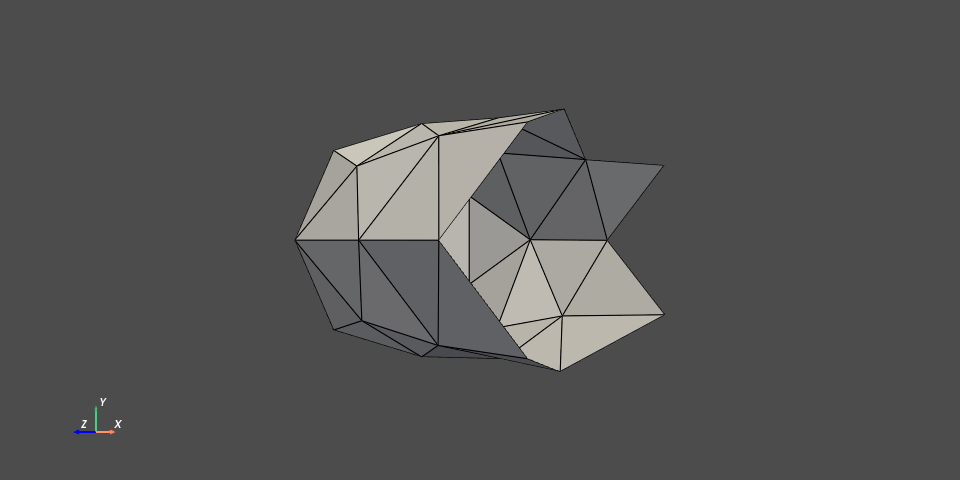

In [5]:
# Visualise this mesh:
p = plot_mesh(surface_mesh, slice_mesh=True)
p.camera.azimuth += 50
p.show(**show_args)

In [6]:
# Tetrahedralise this surface mesh
polydata_mesh = create_polydata_from_pyvista_grid(surface_mesh, face_key='triangle')
tet_mesh = tetgen.TetGen(polydata_mesh)
_ = tet_mesh.tetrahedralize(order=1, mindihedral=20)

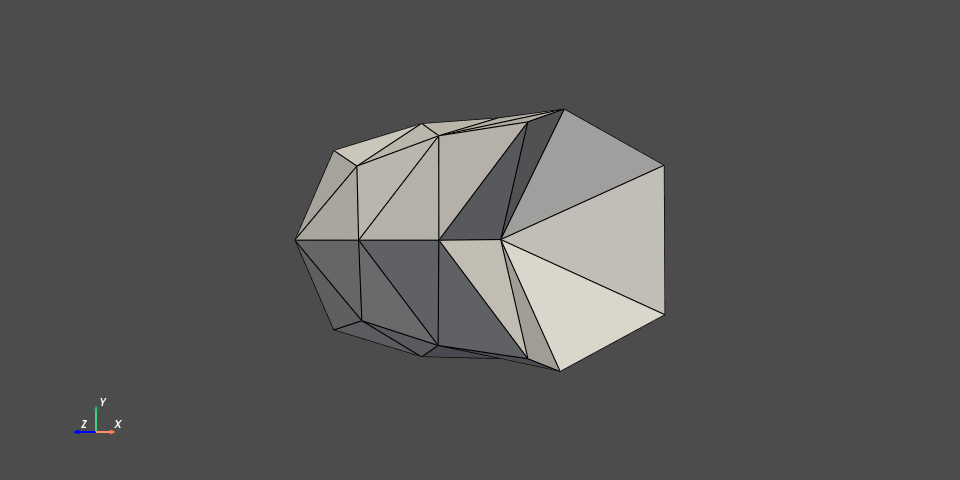

In [7]:
p = plot_mesh(tet_mesh.grid, slice_mesh=True)
p.camera.azimuth += 50
p.show(**show_args)

In [8]:
# Split this tetrahedral mesh into a hexahedral one:
hex_mesh = tetridiv.tet2hex(tet_mesh, output_type='dolfinx')

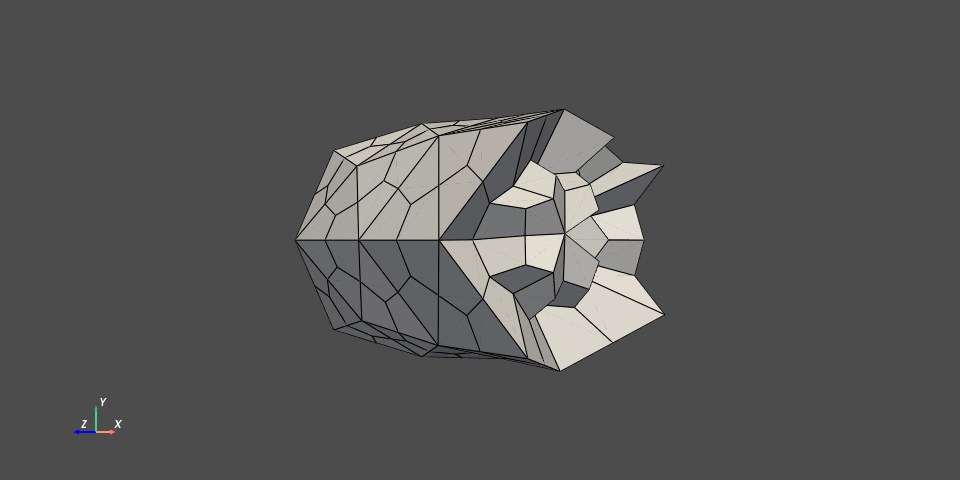

In [9]:
p = plot_mesh(hex_mesh, slice_mesh=True)
p.camera.azimuth += 50
p.show(**show_args)

# Dolfinx Simulation

Now that we've created our hexahedral mesh, let's simulate its deformation under gravity.

In [10]:
C_1 = 5
density = 0.00102
g = 9.81
kappa = 3000
elem_order = 2 
rtol = atol = 1e-9 
max_iter = 50 
num_load_steps = 20
y_rot = 90 
x_rot = 0

In [11]:
u = simulate_neohookean_material(hex_mesh, C_1, density, g, kappa, elem_order, rtol, atol, 
                                 max_iter, num_load_steps, y_rot=y_rot, x_rot=x_rot)

Performing load step 1/20...
Performing load step 2/20...
Performing load step 3/20...
Performing load step 4/20...
Performing load step 5/20...
Performing load step 6/20...
Performing load step 7/20...
Performing load step 8/20...
Performing load step 9/20...
Performing load step 10/20...
Performing load step 11/20...
Performing load step 12/20...
Performing load step 13/20...
Performing load step 14/20...
Performing load step 15/20...
Performing load step 16/20...
Performing load step 17/20...
Performing load step 18/20...
Performing load step 19/20...
Performing load step 20/20...



Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



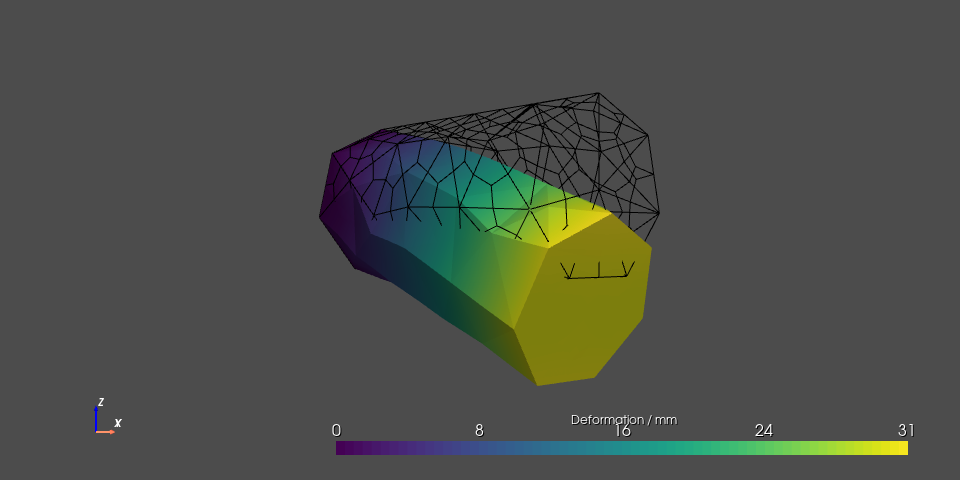

In [12]:
p = plot_deformation(u, hex_mesh)
p.camera.azimuth += 50
p.show(**show_args)